## Cataract Detection Models

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

### Load dataset

In [2]:
dataset_path = '../data'

cataract = Path(dataset_path + '/cataract')
normal = Path(dataset_path + '/normal')

In [3]:
from tqdm import tqdm

disease_type = [cataract, normal]

df = pd.DataFrame()

for types in disease_type:
    for image_path in tqdm(list(types.iterdir()), desc=str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(image_path)], 'disease_type': [disease_type.index(types)]})],
                       ignore_index=True)

../data/normal: 100%|██████████| 1074/1074 [00:00<00:00, 5554.08it/s]


In [4]:
df.head(4)

,image,disease_type
0,../data/cataract/2190_right.jpg,0
1,../data/cataract/_212_7340392.jpg,0
2,../data/cataract/_32_9153320.jpg,0
3,../data/cataract/_224_4070697.jpg,0


In [5]:
df.disease_type.value_counts()

disease_type
1    1074
0    1038
Name: count, dtype: int64

### Visualizing images in Dataset

In [6]:
def plot_image(n, num_samples=3):
    disease_labels = ['cataract', 'normal']
    images = df[df['disease_type'] == n].sample(n=num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.savefig(f'../assets/{disease_labels[n]}.png')
    plt.show()

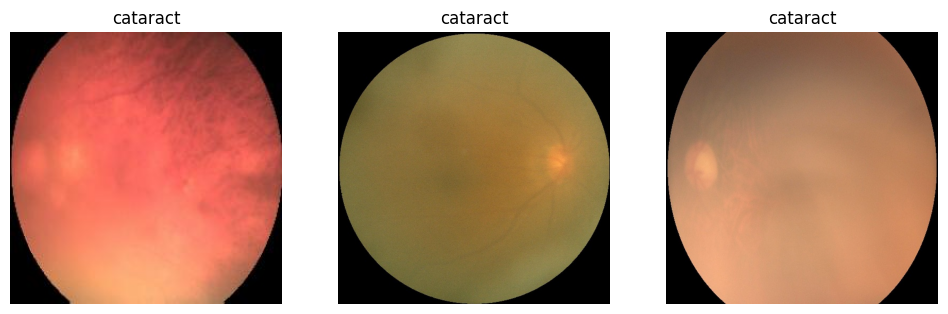

In [7]:
plot_image(0)

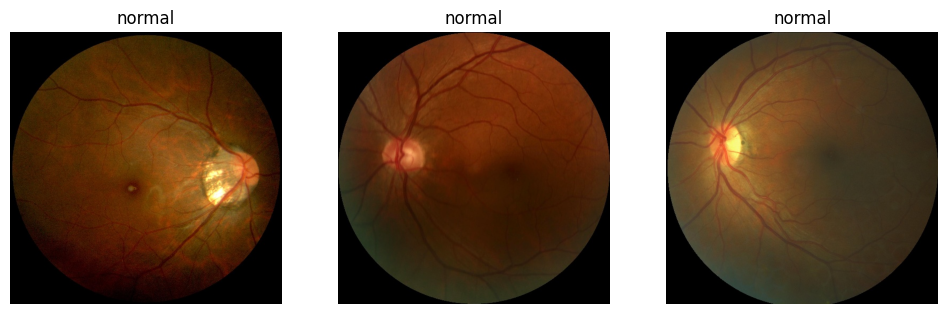

In [8]:
plot_image(1)

In [9]:
df['disease_type'] = df['disease_type'].map({0: 'cataract', 1: 'normal'})
df.disease_type.value_counts()

disease_type
normal      1074
cataract    1038
Name: count, dtype: int64

In [10]:
def extract_features(imagepath):
    try:
        img = cv2.imread(imagepath)

        if img is None:
            print(f'Error loading image: {imagepath}')
            return None

        img_resized = cv2.resize(img, (128, 128))
        gray_image = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        features, _ = hog(gray_image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)
        return features
    except Exception as e:
        return None


In [11]:
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_path = row['image']
    disease_type = row['disease_type']
    feature = extract_features(img_path)
    if feature is not None:
        features.append(feature)
        labels.append(disease_type)


100%|██████████| 2112/2112 [00:58<00:00, 35.99it/s]


In [12]:
X = np.array(features)
y = np.array(labels)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.2s


RandomForestClassifier(random_state=42, verbose=1)

In [14]:
target_names = ['cataract', 'normal']
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Random Forest Classification Report:
              precision    recall  f1-score   support

    cataract       0.94      0.88      0.91       213
      normal       0.89      0.94      0.91       210

    accuracy                           0.91       423
   macro avg       0.91      0.91      0.91       423
weighted avg       0.91      0.91      0.91       423



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [15]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=target_names))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    cataract       0.98      0.64      0.77       213
      normal       0.73      0.99      0.84       210

    accuracy                           0.81       423
   macro avg       0.85      0.81      0.81       423
weighted avg       0.85      0.81      0.81       423



In [16]:
import pickle

with open('../assets/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('../assets/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb, f)
   
with open('../assets/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)